In [90]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [91]:
class consts:
    g = 9.81                # m/s^2
    pi = 3.14159
    mu_0 = 4 * consts.pi * 10 ** -7 # N / A^2

class setup:
    dummy = 0
    wb_SN = 0.0072          # m^2
    wb_div = 0.1            # mWb

    al_S = consts.pi * 9.9 ** 2             # mm^2
    cu_S = consts.pi * 9.9 ** 2             # mm^2
    gr_brk_S = consts.pi * 9.9 ** 2         # mm^2
    gr_sol_S = consts.pi * 8.0 ** 2         # mm^2
    wr_S = consts.pi * 3.2 ** 2             # mm^2

    em_supply = lambda x: 0.005 * x + 0.02  # A
    tl_err = lambda x: 0.05 * x + 10        # mTl
    wb_err = lambda x: 0.015 * x + 0.05     # mWb
    S_err = lambda x: 2 * 0.05 * x          # mm^2
    P_err = lambda: 1.0 * consts.g / 1000   # mN


## Electromagnet calibration

In [92]:
xls = {
    'I, A' : 'I',
    'Phi, divisions' : 'Phi_div',
    'B, mTl' : 'B'
}

em_data = mipt.read_excel("data/341.ods", usecols=['A', 'B', 'C', 'D'], header=[0, 1], nrows=10)
em_data = mipt.map_excel(em_data, xls)

wb_B = em_data[('Webermeter', 'Phi_div')] * setup.wb_div / setup.wb_SN

em_fmt = {
    'Webermeter' : ['Веберметр'],
    'Teslameter' : ['Тесламетр'],
    ('Webermeter', 'I') : ['$I$, А', '{:.2f}', 0],
    ('Webermeter', 'Phi_div') : ['$\Phi$, деления', '{:.1f}', 0],
    ('Webermeter', 'B') : ['$B$, мТл', '{:.0f}', 0],
    ('Teslameter', 'I') : ['$I$, А', '{:.2f}', 0],
    ('Teslameter', 'B') : ['$B$, мТл', '{:.0f}', 0],
}

em_tbl = mipt.table(em_data, em_fmt)
em_tbl.insert(2, ('Webermeter', 'B'), wb_B)
em_tbl.rename().get_data().style.to_latex('gen/electromagnet.tex')

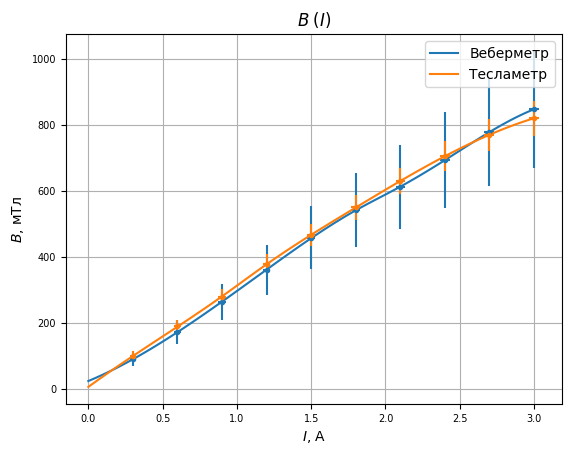

In [93]:
def interp_spl(x, y):
    return UnivariateSpline(x, y)

d = em_tbl.get_data()

x, y, wb_equ = mipt.plot(
    d[('Webermeter', 'I')],
    d[('Webermeter', 'B')],
    xerr = setup.em_supply(d['Webermeter', 'I']),
    yerr = setup.wb_err(d['Webermeter', 'B'] * setup.wb_div / setup.wb_SN),
    x_min = 0,
    func = interp_spl,
    label = 'Веберметр'
)

x, y, tl_equ = mipt.plot(
    d[('Teslameter', 'I')],
    d[('Teslameter', 'B')],
    xerr = setup.em_supply(d[('Teslameter', 'I')]),
    yerr = setup.tl_err(d[('Webermeter', 'B')]),
    x_min = 0,
    func = interp_spl,
    label = 'Тесламетр'
)

plt.title("$B \; (I)$")
plt.xlabel("$I$, А")
plt.ylabel("$B$, мТл")
plt.grid(True)
plt.legend()

plt.savefig("gen/electromagnet_BI.pdf")


## Forces in magnetic field

In [94]:
xls = {
    'I, A' : 'I',
    'dP_straight, mg' : 'dP_s',
    'dP_back, mg' : 'dP_b'
}

def read_and_convertP(cols):
    data = mipt.read_excel("data/341.ods", usecols=cols, header=[0, 1], nrows=10)
    data = mipt.map_excel(data, xls)

    # Convert to mN
    name = data.columns[0][0]
    print(name)
    data[(name, 'dP_s')] *= consts.g / 1000
    data[(name, 'dP_b')] *= consts.g / 1000

    # Convert I to B
    data.insert(1, (name, 'B'), tl_equ(data[(name, 'I')]))
    del data[(name, 'I')]

    return data

cu_data = read_and_convertP(['F', 'G', 'H'])
al_data = read_and_convertP(['J', 'K', 'L'])
gr_brk_data = read_and_convertP(['N', 'O', 'P'])
gr_data = read_and_convertP(['R', 'S', 'T'])
wr1_data = read_and_convertP(['V', 'W', 'X'])
wr2_data = read_and_convertP(['Z', 'AA', 'AB'])
wr_dbl_data = read_and_convertP(['AD', 'AE', 'AF'])


Cuprum
Aluminium
Graphite (broken)
Graphite (solid)
Wolfram1 (single)
Wolfram2 (single)
Wolfram (doubled)


In [95]:
def plot_it(d, label, func = mipt.interp_linear):
    name = d.columns[0][0]
    x, y, equ = mipt.plot(
        d[(name, 'B')] ** 2,
        d[(name, 'dP_s')],
        xerr = 2 * d[(name, 'B')] * setup.tl_err(d[(name, 'B')]),
        yerr = setup.P_err(),
        x_min = 0,
        func = func,
        label = "{}, рост".format(label),
        unique_marker = True
    )
    x_clean = x
    y_clean = y
    x, y, equ = mipt.plot(
        d[(name, 'B')] ** 2,
        d[(name, 'dP_b')],
        xerr = 2 * d[(name, 'B')] * setup.tl_err(d[(name, 'B')]),
        yerr = setup.P_err(),
        x_min = 0,
        func = func,
        label = "{}, падение".format(label),
        unique_marker = True
    )
    x_clean.combine(x, (lambda x1, x2: x1 if x1 < x2 else x2))
    y_clean.combine(y, (lambda x1, x2: x1 if x1 < x2 else x2))
    
    return mipt.mnk(x_clean, y_clean)


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,294720.073358,5.065793e+10,-0.103986,0.005547,-16714.87302,-3.299557e-07,8.869525e-09,-0.006741,0.003289


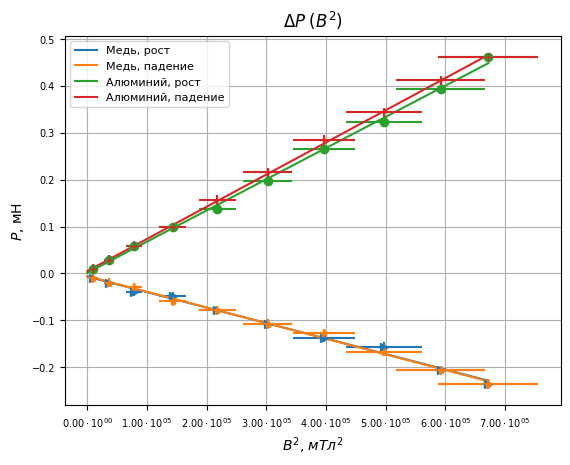

In [96]:
fig = plt.figure()
ax = fig.add_subplot()

mnk_cu = plot_it(cu_data, "Медь")
mnk_al = plot_it(al_data, "Алюминий")

def xfmt(x, y):
    return '${:.2e} }}$'.format(x).replace('e+', '\cdot 10^{')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(xfmt))
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

plt.title("$\Delta P \; (B^2)$")
plt.xlabel("$B^2$, $мТл^2$")
plt.ylabel("$P$, мН")
plt.grid(True)
plt.legend(fontsize = 8)

plt.savefig("gen/cu_al.pdf")
mnk_cu.get_data()


In [97]:
2 * 4 * 3.159 * 10 ** -7 * 0.33 / 3.14159 / 0.01**2


0.0026546302986704185

/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,294720.073358,5.065793e+10,1.635327,0.955625,217842.167147,0.000004,2.156571e-07,0.367955,0.079973


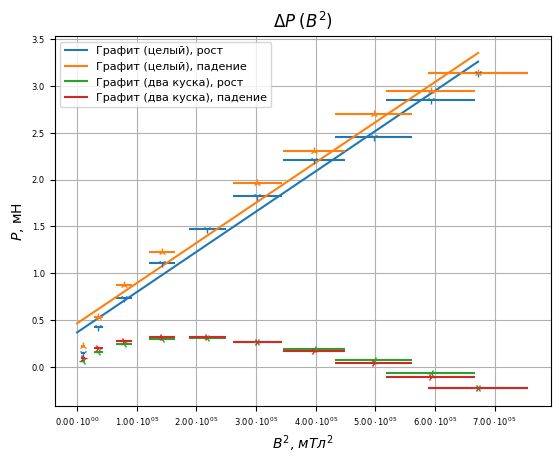

In [98]:
fig = plt.figure()
ax = fig.add_subplot()

mnk_gr = plot_it(gr_data, "Графит (целый)")
mnk_gr_brk = plot_it(gr_brk_data, "Графит (два куска)", func=None)

def xfmt(x, y):
    return '${:.2e} }}$'.format(x).replace('e+', '\cdot 10^{')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(xfmt))
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

plt.title("$\Delta P \; (B^2)$")
plt.xlabel("$B^2$, $мТл^2$")
plt.ylabel("$P$, мН")
plt.grid(True)
plt.legend(fontsize = 8)

plt.savefig("gen/gr.pdf")
mnk_gr.get_data()

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,294720.073358,5.065793e+10,0.12753,0.010894,23461.25435,4.631309e-07,8.355711e-09,-0.008964,0.003099


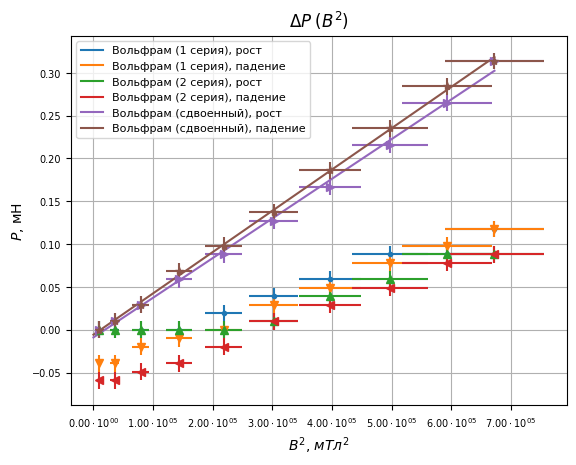

In [99]:
fig = plt.figure()
ax = fig.add_subplot()

mnk_wr1 = plot_it(wr1_data, "Вольфрам (1 серия)", func = None)
mnk_wr2 = plot_it(wr2_data, "Вольфрам (2 серия)", func = None)
mnk_wr_dbl = plot_it(wr_dbl_data, "Вольфрам (сдвоенный)")

def xfmt(x, y):
    return '${:.2e} }}$'.format(x).replace('e', '\cdot 10^{').replace('+', '')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(xfmt))
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

plt.title("$\Delta P \; (B^2)$")
plt.xlabel("$B^2$, $мТл^2$")
plt.ylabel("$P$, мН")
plt.grid(True)
plt.legend(fontsize = 8)

plt.savefig("gen/wr.pdf")

mnk_wr_dbl.get_data()

In [104]:
def eval_chi(name, mnk_val, S):
    d = mnk_val.get_data()
    
    chi = float(d['a']) * 2 * consts.mu_0 / S * 1000 ** 3
    chi_err = abs(chi * setup.S_err(S) / S)

    print("{}: chi = ({:.2e} +- {:.2e})".format(name, chi, chi_err))

    return chi


In [105]:
chi_cu = eval_chi('Cu', mnk_cu, setup.cu_S)
chi_al = eval_chi('Al', mnk_al, setup.al_S)

chi_gr = eval_chi('Gr', mnk_gr, setup.gr_sol_S)
chi_wr = eval_chi('Wr (doubled)', mnk_wr_dbl, setup.wr_S * 2)


Cu: chi = (-2.69e-06 +- 2.69e-07)
Al: chi = (5.42e-06 +- 5.42e-07)
Gr: chi = (5.38e-05 +- 5.38e-06)
Wr (doubled): chi = (1.81e-05 +- 1.81e-06)


In [108]:
print((2.2 * 10 ** -5) / (9.63 * 10 ** -6))
print(chi_al / chi_cu)

print((6.4 * 10 ** -4) / (9.63 * 10 ** -6))
print(chi_gr / chi_cu)


2.284527518172378
-2.0140585205926436
66.45898234683281
-19.95856360310925


### Method B

In [19]:
mm = np.sqrt(8 * setup.F * setup.r**4 / (3 * 1.08) )
mm_err = mm * 1/2 * np.sqrt( (4 * setup.r_err/setup.r)**2 + (setup.F_err/setup.F)**2  )
print('mm = ({} +- {}) Gauss * cm^3'.format(mm, mm_err))

B_p = 2 * mm / setup.r ** 3 
B_p_err = B_p * np.sqrt( (mm_err/mm)**2 + (3 * setup.r_err / setup.r)**2 )
print('B_p = ({} +- {}) Gauss'.format(B_p, B_p_err))

M = mm / (4/3 * 3.14 * setup.r**3)
M_err = M * np.sqrt( (mm_err/mm)**2 + (3 * setup.r_err/setup.r)**2 )
print('M = ({} +- {}) Gauss'.format(M, M_err))

B_r = 3/2 * B_p
B_r_err = B_r * B_p_err/B_p
print('B_r = ({} +- {}) Gauss'.format(B_r, B_r_err))

# Setting magnetic moment
setup.mm = mm
setup.mm_err = mm_err

mm = (81.33626407625295 +- 1.5458439735532217) Gauss * cm^3
B_p = (5229.404868891203 +- 111.20377909360737) Gauss
M = (624.5308362529302 +- 13.280706101943554) Gauss
B_r = (7844.107303336804 +- 166.80566864041106) Gauss


## Horizontal

In [20]:
xls = {
    'T, s' : 'T'
}

h_data = mipt.read_excel("data/313.ods", usecols=range(0, 2), header=[0, 1], nrows=10)
h_data = mipt.map_excel(h_data, xls)
h_data

Horizontal          
           n         T
0         12  5.268000
1         11  4.970000
2         10  4.538000
3          9  4.100000
4          8  3.968000
5          7  3.556000
6          6  3.374000
7          5  3.323333
8          4  3.006000

In [21]:
h_fmt = {
    'Horizontal' : ['Горизонтальная составляющая'],
    ('Horizontal', 'n') : ['$n$', '{:.0f}', 0],
    ('Horizontal', 'T') : ['$T$, с', '{:.2f}', 0]
}

h_tbl = mipt.table(h_data, h_fmt)
h_tbl.rename().to_latex('gen/horizontal.tex')
h_tbl.rename().get_data()

Горизонтальная составляющая          
                          $n$    $T$, с
0                          12  5.268000
1                          11  4.970000
2                          10  4.538000
3                           9  4.100000
4                           8  3.968000
5                           7  3.556000
6                           6  3.374000
7                           5  3.323333
8                           4  3.006000

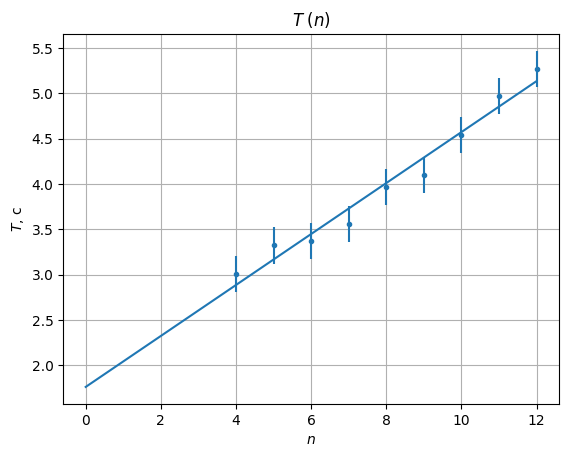

In [22]:
d = h_tbl.get_data()
x, y, equ = mipt.plot(d[('Horizontal', 'n')], d[('Horizontal', 'T')], x_min = 0, yerr = setup.T_err)

plt.title("$T \; (n)$")
plt.xlabel("$n$")
plt.ylabel("$T$, с")
plt.grid(True)

plt.savefig("gen/horizontal_Tn.pdf")


In [23]:
h_mnk = mipt.mnk(d[('Horizontal', 'n')], d[('Horizontal', 'T')], file = 'gen/horizontal_mnk.tex').get_data()
h_mnk

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,8.0,6.666667,4.011481,0.542548,1.873333,0.281,0.018598,1.763481,0.156341


In [24]:
B_par = 3.14159**2 * setup.m * (setup.r * 2)**2 / (3 * setup.mm * float(h_mnk['a'])**2)
B_par_err = B_par * np.sqrt( (setup.m_err/setup.m)**2 + (setup.mm_err/setup.mm)**2
                             + (2 * setup.r_err/setup.r)**2 + (float(h_mnk['da'])/float(h_mnk['a']))**2 )
print('B_parallel = ({:.2e} +- {:.2e})'.format(B_par, B_par_err))

B_parallel = (1.69e-01 +- 1.17e-02)


## Vertical

In [25]:
xls = {
    'm, mg' : 'm',
    'l, balls' : 'l'
}

v_data = mipt.read_excel("data/313.ods", usecols=range(3, 6), header=[0, 1], nrows=5)
v_data = mipt.map_excel(v_data, xls)
v_data

Vertical          
         n    m    l
0       12  308  6.0
1       10  308  4.2
2        8  308  3.5
3        6  308  2.8
4        4  308  1.8

In [26]:
v_L = v_data[('Vertical', 'l')] * 2 * setup.r
v_L_err = setup.r

v_M = v_data[('Vertical', 'm')] * v_L * consts.g / 1000
v_M_err = v_M * v_L_err/v_L
print(v_M)

v_fmt = {
    'Vertical' : ['Вертикальная составляющая'],
    ('Vertical', 'n') : ['$n$', '{:.0f}', 0],
    ('Vertical', 'm') : ['$m$, мг', '{:.0f}', 0],
    ('Vertical', 'l') : ['$l$, шарики', '{:.1f}', 0],
    ('Vertical', 'L') : ['$l$, cм', '{:.2f}', 0],
    ('Vertical', 'M') : ['$M$, дин $\cdot$ см', '{:.0f}', 0]
}

v_tbl = mipt.table(v_data, v_fmt)
v_tbl.insert(3, ('Vertical', 'L'), v_L)
v_tbl.insert(4, ('Vertical', 'M'), v_M)
v_tbl.rename().to_latex('gen/vertical.tex')
v_tbl.rename().get_data()

0    1140.306552
1     798.214586
2     665.178822
3     532.143058
4     342.091966
dtype: float64


Вертикальная составляющая                                                
                        $n$ $m$, мг $l$, шарики $l$, cм $M$, дин $\cdot$ см
0                        12     308         6.0  3.7740         1140.306552
1                        10     308         4.2  2.6418          798.214586
2                         8     308         3.5  2.2015          665.178822
3                         6     308         2.8  1.7612          532.143058
4                         4     308         1.8  1.1322          342.091966

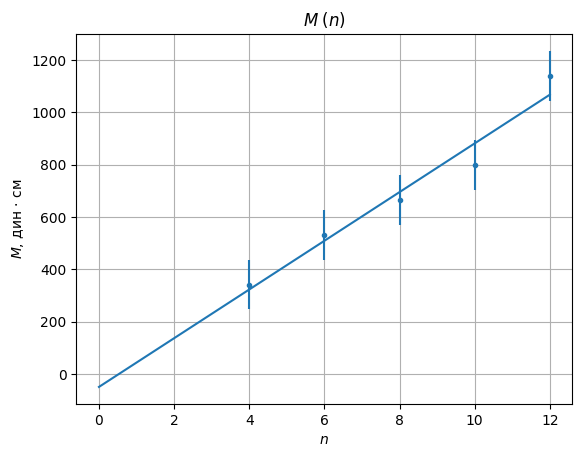

In [27]:
d = v_tbl.get_data()
x, y, equ = mipt.plot(d[('Vertical', 'n')], d[('Vertical', 'M')], x_min = 0, yerr = v_M_err)

plt.title("$M \; (n)$")
plt.xlabel("$n$")
plt.ylabel("$M$, дин $\cdot$ см")
plt.grid(True)

plt.savefig("gen/vertical_Mn.pdf")


In [28]:
v_mnk = mipt.mnk(d[('Vertical', 'n')], d[('Vertical', 'M')], file = 'gen/vertical_mnk.tex').get_data()
v_mnk

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,8.0,8.0,695.586997,72181.044073,745.000281,93.125035,10.806763,-49.413284,91.698421


In [29]:
B_perp = float(v_mnk['a']) / setup.mm
B_perp_err = B_perp * np.sqrt( (setup.mm_err/setup.mm)**2 + (float(v_mnk['da'])/float(v_mnk['a']))**2 )
print('B_perp = ({:.2e} +- {:.2e})'.format(B_perp, B_perp_err))

B_perp = (1.14e+00 +- 1.35e-01)


In [30]:
beta = np.arctan(B_perp/B_par) * 180 / np.pi
print(beta)
B = (B_par ** 2 + B_perp ** 2) ** 0.5
print("{:.2f} Gauss".format(B))
print("{:.2f} nT".format(B_perp * 10 ** (-4 + 9)))
print("{:.2f} nT".format(B_par * 10 ** (-4 + 9)))


81.62557409363752
1.16 Gauss
114493.87 nT
16854.77 nT
